## Summary
1. This is a simple model development pipeline intended for those who are interested in learning ML.
2. I plan to use this project as a basis to experiment with new ML techniques, learn more about HFT, and hopefully collaborate and learn from like-minded learners. 
3. If you would like to become a collaborator feel free to reach out to me on LinkedIn www.linkedin.com/in/mamouei.

## Import packages

In [24]:
from datetime import timedelta
from tqdm.notebook import tqdm
import time
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import lightgbm as lgb

from alpaca.data import StockHistoricalDataClient, TimeFrame
from alpaca.data.requests import StockQuotesRequest, StockBarsRequest

import pandas as pd
import ta

# 1. Load raw data

In [2]:
ALPACA_API_KEY_ID = '*****'        #Replace this with your API access keys  
ALPACA_API_SECRET_KEY = '*****'

# Instantiate a data client
data_client = StockHistoricalDataClient(ALPACA_API_KEY_ID, ALPACA_API_SECRET_KEY)

# Set the start time for loading historical data
start_time = pd.to_datetime("2020-01-01").tz_localize('America/New_York')

# Set request parameters, you can add an end date here, but if you don't all data until present will be loaded. 
request_params = StockBarsRequest(
    symbol_or_symbols=['GOOGL','NVDA','MSFT','AAPL'], #Set tickers you would like to load
    timeframe=TimeFrame.Hour,                         #Set the granualarity of the data, this will output hourly data
    start=start_time                                  #Set the start time
    )

bars_df = data_client.get_stock_bars(request_params).df.tz_convert('America/New_York', level=1)

In [3]:
bars_df.head()

open    high      low     close  \
symbol timestamp                                                        
AAPL   2020-01-02 04:00:00-05:00  295.0500  295.75  295.050  295.7300   
       2020-01-02 05:00:00-05:00  295.7500  296.05  295.750  296.0000   
       2020-01-02 06:00:00-05:00  295.7500  295.85  295.300  295.5100   
       2020-01-02 07:00:00-05:00  295.5000  296.18  295.130  296.1000   
       2020-01-02 08:00:00-05:00  295.8898  296.75  295.435  296.6803   

                                    volume  trade_count        vwap  
symbol timestamp                                                     
AAPL   2020-01-02 04:00:00-05:00   26138.0        191.0  295.438169  
       2020-01-02 05:00:00-05:00   15543.0        146.0  295.947596  
       2020-01-02 06:00:00-05:00   14890.0        163.0  295.580787  
       2020-01-02 07:00:00-05:00  134301.0       1219.0  295.835031  
       2020-01-02 08:00:00-05:00  215866.0       2080.0  296.239297

In [132]:
#save the data for future reference
#bars_df.to_csv('data/bars_hourly_20200101_GGL_NVD_MS_APL.csv')

# 2. feature engineering

In [5]:
bars_df=bars_df.reset_index()
bars_df['delta_HL']=bars_df["high"]-bars_df["low"]

#bars_df=bars_df.set_index('timestamp')

In [10]:
symbols=bars_df.symbol.unique()

feature_columns=['last_value_open','last_value_high','last_value_low','last_value_close','last_value_volume','last_value_trade_count','last_value_vwap','last_value_delta_HL','diff_last_open','diff_last_high','diff_last_low','diff_last_close','diff_last_volume','diff_last_trade_count','diff_last_vwap','diff_last_delta_HL','mean_last_3b_open','mean_last_3b_high','mean_last_3b_low','mean_last_3b_close','mean_last_3b_volume','mean_last_3b_trade_count','mean_last_3b_vwap','mean_last_3b_delta_HL','std_last_3b_open','std_last_3b_high','std_last_3b_low','std_last_3b_close','std_last_3b_volume','std_last_3b_trade_count','std_last_3b_vwap','std_last_3b_delta_HL','mean_last_16b_open','mean_last_16b_high','mean_last_16b_low','mean_last_16b_close','mean_last_16b_volume','mean_last_16b_trade_count','mean_last_16b_vwap','mean_last_16b_delta_HL','std_last_16b_open','std_last_16b_high','std_last_16b_low','std_last_16b_close','std_last_16b_volume','std_last_16b_trade_count','std_last_16b_vwap','std_last_16b_delta_HL','mean_last_48b_open','mean_last_48b_high','mean_last_48b_low','mean_last_48b_close','mean_last_48b_volume','mean_last_48b_trade_count','mean_last_48b_vwap','mean_last_48b_delta_HL','std_last_48b_open','std_last_48b_high','std_last_48b_low','std_last_48b_close','std_last_48b_volume','std_last_48b_trade_count','std_last_48b_vwap','std_last_48b_delta_HL','mean_last_100b_open','mean_last_100b_high','mean_last_100b_low','mean_last_100b_close','mean_last_100b_volume','mean_last_100b_trade_count','mean_last_100b_vwap','mean_last_100b_delta_HL','std_last_100b_open','std_last_100b_high','std_last_100b_low','std_last_100b_close','std_last_100b_volume','std_last_100b_trade_count','std_last_100b_vwap','std_last_100b_delta_HL','ratio_last_mean_past3_open','ratio_last_mean_past3_high','ratio_last_mean_past3_low','ratio_last_mean_past3_close','ratio_last_mean_past3_volume','ratio_last_mean_past3_trade_count','ratio_last_mean_past3_vwap','ratio_last_mean_past3_delta_HL','ratio_last_std_past3_open','ratio_last_std_past3_high','ratio_last_std_past3_low','ratio_last_std_past3_close','ratio_last_std_past3_volume','ratio_last_std_past3_trade_count','ratio_last_std_past3_vwap','ratio_last_std_past3_delta_HL','ratio_last_mean_past16_open','ratio_last_mean_past16_high','ratio_last_mean_past16_low','ratio_last_mean_past16_close','ratio_last_mean_past16_volume','ratio_last_mean_past16_trade_count','ratio_last_mean_past16_vwap','ratio_last_mean_past16_delta_HL','ratio_last_std_past16_open','ratio_last_std_past16_high','ratio_last_std_past16_low','ratio_last_std_past16_close','ratio_last_std_past16_volume','ratio_last_std_past16_trade_count','ratio_last_std_past16_vwap','ratio_last_std_past16_delta_HL','ratio_last_mean_past48_open','ratio_last_mean_past48_high','ratio_last_mean_past48_low','ratio_last_mean_past48_close','ratio_last_mean_past48_volume','ratio_last_mean_past48_trade_count','ratio_last_mean_past48_vwap','ratio_last_mean_past48_delta_HL','ratio_last_std_past48_open','ratio_last_std_past48_high','ratio_last_std_past48_low','ratio_last_std_past48_close','ratio_last_std_past48_volume','ratio_last_std_past48_trade_count','ratio_last_std_past48_vwap','ratio_last_std_past48_delta_HL','ratio_past3_mean_past16_open','ratio_past3_mean_past16_high','ratio_past3_mean_past16_low','ratio_past3_mean_past16_close','ratio_past3_mean_past16_volume','ratio_past3_mean_past16_trade_count','ratio_past3_mean_past16_vwap','ratio_past3_mean_past16_delta_HL','ratio_past3_std_past16_open','ratio_past3_std_past16_high','ratio_past3_std_past16_low','ratio_past3_std_past16_close','ratio_past3_std_past16_volume','ratio_past3_std_past16_trade_count','ratio_past3_std_past16_vwap','ratio_past3_std_past16_delta_HL','ratio_past16_mean_past48_open','ratio_past16_mean_past48_high','ratio_past16_mean_past48_low','ratio_past16_mean_past48_close','ratio_past16_mean_past48_volume','ratio_past16_mean_past48_trade_count','ratio_past16_mean_past48_vwap','ratio_past16_mean_past48_delta_HL','ratio_past16_std_past48_open','ratio_past16_std_past48_high','ratio_past16_std_past48_low','ratio_past16_std_past48_close','ratio_past16_std_past48_volume','ratio_past16_std_past48_trade_count','ratio_past16_std_past48_vwap','ratio_past16_std_past48_delta_HL','ratio_past48_mean_past100_open','ratio_past48_mean_past100_high','ratio_past48_mean_past100_low','ratio_past48_mean_past100_close','ratio_past48_mean_past100_volume','ratio_past48_mean_past100_trade_count','ratio_past48_mean_past100_vwap','ratio_past48_mean_past100_delta_HL','ratio_past48_std_past100_open','ratio_past48_std_past100_high','ratio_past48_std_past100_low','ratio_past48_std_past100_close','ratio_past48_std_past100_volume','ratio_past48_std_past100_trade_count','ratio_past48_std_past100_vwap','ratio_past48_std_past100_delta_HL','zscore_last_past3_open','zscore_last_past3_high','zscore_last_past3_low','zscore_last_past3_close','zscore_last_past3_volume','zscore_last_past3_trade_count','zscore_last_past3_vwap','zscore_last_past3_delta_HL','zscore_last_past16_open','zscore_last_past16_high','zscore_last_past16_low','zscore_last_past16_close','zscore_last_past16_volume','zscore_last_past16_trade_count','zscore_last_past16_vwap','zscore_last_past16_delta_HL','zscore_last_past48_open','zscore_last_past48_high','zscore_last_past48_low','zscore_last_past48_close','zscore_last_past48_volume','zscore_last_past48_trade_count','zscore_last_past48_vwap','zscore_last_past48_delta_HL','zscore_last_past100_open','zscore_last_past100_high','zscore_last_past100_low','zscore_last_past100_close','zscore_last_past100_volume','zscore_last_past100_trade_count','zscore_last_past100_vwap','zscore_last_past100_delta_HL','zscore_pas3_past16_open','zscore_pas3_past16_high','zscore_pas3_past16_low','zscore_pas3_past16_close','zscore_pas3_past16_volume','zscore_pas3_past16_trade_count','zscore_pas3_past16_vwap','zscore_pas3_past16_delta_HL','zscore_past3_past48_open','zscore_past3_past48_high','zscore_past3_past48_low','zscore_past3_past48_close','zscore_past3_past48_volume','zscore_past3_past48_trade_count','zscore_past3_past48_vwap','zscore_past3_past48_delta_HL','zscore_past3_past100_open','zscore_past3_past100_high','zscore_past3_past100_low','zscore_past3_past100_close','zscore_past3_past100_volume','zscore_past3_past100_trade_count','zscore_past3_past100_vwap','zscore_past3_past100_delta_HL']
features_df_all=pd.DataFrame()
cols=["open","high","low", "close","volume","trade_count","vwap","delta_HL"]
#symbols=['AAPL']

for symbol in symbols:
    print(symbol)
    bars_df_symbol=bars_df[bars_df['symbol']==symbol]
    bars_df_symbol.sort_values(by='timestamp')
    
    f0=bars_df_symbol[cols].rolling(window=5,closed='left').mean().rename(columns={col:'sma_5L_'+col for col in cols})   #all values will be normalised by this
    f00=bars_df_symbol[cols].ewm(span=5, adjust=False).mean().rename(columns={col:'ewm_5L_'+col for col in cols}).rolling(window=1, closed='left').apply(lambda x:x.iloc[0])
    
    #simple historical stats
    f1=bars_df_symbol[cols].rolling(window=2, closed='left').apply(lambda x:x.iloc[1]-x.iloc[0]).rename(columns={col:'diff_2L_'+col for col in cols})/f0.values #diff between the last two values
    f2=bars_df_symbol[cols].rolling(window=1, closed='left').apply(lambda x:x.iloc[0]).rename(columns={col:'last_value_'+col for col in cols})
    f2_2=f2.rename(columns={key:'last_value_nrmlz_'+value for key,value in zip(f2.columns,cols)})/f0.values

    f3=bars_df_symbol[cols].rolling(window=3, closed='left').mean().rename(columns={col:'sma_3L_'+col for col in cols})/f0.values
    f4=bars_df_symbol[cols].rolling(window=5, closed='left').mean().rename(columns={col:'sma_5L_'+col for col in cols})/f0.values
    f5=bars_df_symbol[cols].rolling(window=10,closed='left').mean().rename(columns={col:'sma_10L_'+col for col in cols})/f0.values
    f6=bars_df_symbol[cols].rolling(window=20,closed='left').mean().rename(columns={col:'sma_20L_'+col for col in cols})/f0.values
    f7=bars_df_symbol[cols].rolling(window=40,closed='left').mean().rename(columns={col:'sma_40L_'+col for col in cols})/f0.values
    f8=bars_df_symbol[cols].rolling(window=80,closed='left').mean().rename(columns={col:'sma_80L_'+col for col in cols})/f0.values
        
    f9=bars_df_symbol[cols].rolling(window=3,  closed='left').std().rename(columns={col:'std_3L_'+col for col in cols})/f0.values
    f10=bars_df_symbol[cols].rolling(window=5, closed='left').std().rename(columns={col:'std_5L_'+col for col in cols})/f0.values
    f11=bars_df_symbol[cols].rolling(window=10,closed='left').std().rename(columns={col:'std_10L_'+col for col in cols})/f0.values
    f12=bars_df_symbol[cols].rolling(window=20,closed='left').std().rename(columns={col:'std_20L_'+col for col in cols})/f0.values
    f13=bars_df_symbol[cols].rolling(window=40,closed='left').std().rename(columns={col:'std_40L_'+col for col in cols})/f0.values
    f14=bars_df_symbol[cols].rolling(window=80,closed='left').std().rename(columns={col:'std_80L_'+col for col in cols})/f0.values

    #ratios
    f15=(f2/f3.values).rename(columns={key:'ratio_last_mean3L_'+val for key,val in zip(f2.columns,cols)})
    f16=(f2/f4.values).rename(columns={key:'ratio_last_mean5L_'+val for key,val in zip(f2.columns,cols)})
    f17=(f2/f5.values).rename(columns={key:'ratio_last_mean10L_'+val for key,val in zip(f2.columns,cols)})
    f18=(f2/f6.values).rename(columns={key:'ratio_last_mean20L_'+val for key,val in zip(f2.columns,cols)})
    f19=(f2/f7.values).rename(columns={key:'ratio_last_mean40L_'+val for key,val in zip(f2.columns,cols)})
    f20=(f2/f8.values).rename(columns={key:'ratio_last_mean80L_'+val for key,val in zip(f2.columns,cols)})

    f21=(f2/f9.values).rename( columns={key:'ratio_last_std3L_'+val for key,val in zip(f2.columns,cols)})
    f22=(f2/f10.values).rename(columns={key:'ratio_last_std5L_'+val for key,val in zip(f2.columns,cols)})
    f23=(f2/f11.values).rename(columns={key:'ratio_last_std10L_'+val for key,val in zip(f2.columns,cols)})
    f24=(f2/f12.values).rename(columns={key:'ratio_last_std20L_'+val for key,val in zip(f2.columns,cols)})
    f25=(f2/f13.values).rename(columns={key:'ratio_last_std40L_'+val for key,val in zip(f2.columns,cols)})
    f26=(f2/f14.values).rename(columns={key:'ratio_last_std80L_'+val for key,val in zip(f2.columns,cols)})


    f27=(f3/f4.values).rename(columns={key:'ratio_past3_mean5L_'+val for key,val in zip(f3.columns,cols)})
    f28=(f3/f5.values).rename(columns={key:'ratio_past3_mean10L_'+val for key,val in zip(f3.columns,cols)})
    f29=(f3/f6.values).rename(columns={key:'ratio_past3_mean20L_'+val for key,val in zip(f3.columns,cols)})
    f30=(f3/f7.values).rename(columns={key:'ratio_past3_mean40L_'+val for key,val in zip(f3.columns,cols)})
    f31=(f3/f8.values).rename(columns={key:'ratio_past3_mean80L_'+val for key,val in zip(f3.columns,cols)})

    f32=(f3/f9.values).rename( columns={key:'ratio_past3_std3L_'+val for key,val in zip(f3.columns,cols)})
    f33=(f3/f10.values).rename(columns={key:'ratio_past3_std5L_'+val for key,val in zip(f3.columns,cols)})
    f34=(f3/f11.values).rename(columns={key:'ratio_past3_std10L_'+val for key,val in zip(f3.columns,cols)})
    f35=(f3/f12.values).rename(columns={key:'ratio_past3_std20L_'+val for key,val in zip(f3.columns,cols)})
    f36=(f3/f13.values).rename(columns={key:'ratio_past3_std40L_'+val for key,val in zip(f3.columns,cols)})
    f37=(f3/f14.values).rename(columns={key:'ratio_past3_std80L_'+val for key,val in zip(f3.columns,cols)})


    f38=(f5/f6.values).rename(columns={key:'ratio_past10_mean20L_'+val for key,val in zip(f5.columns,cols)})
    f39=(f5/f7.values).rename(columns={key:'ratio_past10_mean40L_'+val for key,val in zip(f5.columns,cols)})
    f40=(f5/f8.values).rename(columns={key:'ratio_past10_mean80L_'+val for key,val in zip(f5.columns,cols)})

    f41=(f5/f12.values).rename(columns={key:'ratio_past10_std20L_'+val for key,val in zip(f5.columns,cols)})
    f42=(f5/f13.values).rename(columns={key:'ratio_past10_std40L_'+val for key,val in zip(f5.columns,cols)})
    f43=(f5/f14.values).rename(columns={key:'ratio_past10_std80L_'+val for key,val in zip(f5.columns,cols)})

    #z-score
    f44=pd.DataFrame(f2.values-f3.values, columns=['zscore_last_past3_'+col for col in cols], index=f2.index)/f9.values
    f45=pd.DataFrame(f2.values-f4.values, columns=['zscore_last_past5_'+col for col in cols], index=f2.index)/f10.values
    f46=pd.DataFrame(f2.values-f5.values, columns=['zscore_last_past10_'+col for col in cols], index=f2.index)/f11.values
    f47=pd.DataFrame(f2.values-f6.values, columns=['zscore_last_past20_'+col for col in cols], index=f2.index)/f12.values
    f48=pd.DataFrame(f2.values-f7.values, columns=['zscore_last_past40_'+col for col in cols], index=f2.index)/f13.values
    f49=pd.DataFrame(f2.values-f8.values, columns=['zscore_last_past80_'+col for col in cols], index=f2.index)/f14.values


    f50=pd.DataFrame(f3.values-f5.values, columns=['zscore_past3_past10_'+col for col in cols], index=f3.index)/f11.values
    f51=pd.DataFrame(f3.values-f6.values, columns=['zscore_past3_past20_'+col for col in cols], index=f3.index)/f12.values
    f52=pd.DataFrame(f3.values-f7.values, columns=['zscore_past3_past40_'+col for col in cols], index=f3.index)/f13.values
    f53=pd.DataFrame(f3.values-f8.values, columns=['zscore_past3_past80_'+col for col in cols], index=f3.index)/f14.values

    f54=pd.DataFrame(f4.values-f5.values, columns=['zscore_past5_past10_'+col for col in cols], index=f4.index)/f11.values
    f55=pd.DataFrame(f4.values-f6.values, columns=['zscore_past5_past20_'+col for col in cols], index=f4.index)/f12.values
    f56=pd.DataFrame(f4.values-f7.values, columns=['zscore_past5_past40_'+col for col in cols], index=f4.index)/f13.values
    f57=pd.DataFrame(f4.values-f8.values, columns=['zscore_past5_past80_'+col for col in cols], index=f3.index)/f14.values

    #add percentage change std 3to16 and 16to48 to capture uncertainty/volatility
    f58=pd.DataFrame(f9.values-f11.values, columns=['std_perc_change_past3_past10_'+col for col in cols], index=f4.index)/f11.values
    f59=pd.DataFrame(f9.values-f12.values, columns=['std_perc_change_past3_past20_'+col for col in cols], index=f4.index)/f12.values
    f60=pd.DataFrame(f9.values-f14.values, columns=['std_perc_change_past3_past80_'+col for col in cols], index=f4.index)/f14.values

    f61=pd.DataFrame(f10.values-f11.values, columns=['std_perc_change_past5_past10_'+col for col in cols], index=f4.index)/f11.values
    f62=pd.DataFrame(f10.values-f12.values, columns=['std_perc_change_past5_past20_'+col for col in cols], index=f4.index)/f12.values
    f63=pd.DataFrame(f10.values-f14.values, columns=['std_perc_change_past5_past80_'+col for col in cols], index=f4.index)/f14.values

    #tech indicators
    f64=pd.DataFrame(f0.values-f00.values, columns=['diff_sma5_ewm5_'+col for col in cols], index=f4.index)/f0.values

    f65=ta.add_all_ta_features(bars_df_symbol.copy(), open="open", high="high", low="low", close="close", volume="volume")\
.drop(columns=bars_df_symbol.columns)\
.rolling(window=1, closed='left').apply(lambda x:x.iloc[0])


    features_df=pd.concat([f1, f2,f2_2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24, f25, f26, f27, f28, f29, f30, 
               f31, f32, f33, f34, f35, f36, f37, f38, f39, f40, f41, f42, f43, f44, f45, f46, f47, f48, f49, f50, f51, f52, f53, f54, f55, f56, f57, f58,
               f59, f60, f61, f62, f63, f64, f65],axis=1)

    #join with hour bars for prediction
    dates=pd.to_datetime(bars_df_symbol.timestamp.astype(str).str[:13])
    features_df['hour_of_day']=dates.dt.hour
    features_df['day_of_week']=dates.dt.dayofweek
    features_df['month_of_year']=dates.dt.month

    #join with hour bars for prediction
    features_df=features_df.join(bars_df_symbol,how='left')
    features_df['high_next2']=features_df.high.rolling(window=3, closed='right', center=True).apply(lambda x:x.iloc[1:3].max())
    features_df['low_next2']=features_df.low.rolling(window=3, closed='right', center=True).apply(lambda x:x.iloc[1:3].min())

    


    #fl_df['symbol']=symbol
    
    


    features_df_all=pd.concat([features_df_all,features_df])




#label
features_df_all['label']=(features_df_all['high']>=1.01*features_df_all['last_value_close'])

AAPL
GOOGL
MSFT
NVDA


In [56]:
#fl_df_all.to_csv('data/fl_hourly_20200101_GGL_NVD_MS_APL.csv')

# Model training 

In [11]:
import lightgbm as lgb

In [21]:
features_df_all.head()

,diff_2L_open,diff_2L_high,diff_2L_low,diff_2L_close,diff_2L_volume,diff_2L_trade_count,diff_2L_vwap,diff_2L_delta_HL,last_value_open,last_value_high,...,high,low,close,volume,trade_count,vwap,delta_HL,high_next2,low_next2,label
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,295.75,295.050,295.7300,26138.0,191.0,295.438169,0.700,NaN,NaN,False
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295.05,295.75,...,296.05,295.750,296.0000,15543.0,146.0,295.947596,0.300,296.05,295.30,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295.75,296.05,...,295.85,295.300,295.5100,14890.0,163.0,295.580787,0.550,296.18,295.13,False
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295.75,295.85,...,296.18,295.130,296.1000,134301.0,1219.0,295.835031,1.050,296.75,295.13,False
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295.50,296.18,...,296.75,295.435,296.6803,215866.0,2080.0,296.239297,1.315,298.15,295.19,False


In [15]:
columns_to_exclude=['timestamp', 'open', 'high', 'low', 'close',
       'volume', 'trade_count', 'vwap', 'delta_HL', 'high_next2', 'low_next2',
       'label']

In [17]:
#fl_df=pd.read_csv('data/fl_hourly_20200101_GGL_NVD_MS_APL.csv',index_col='timestamp')
feature_columns=[col for col in features_df_all.columns if col not in columns_to_exclude ]
categorical=['symbol']

In [19]:
for cat in categorical:
    features_df_all[cat]=features_df_all[cat].astype("category")

In [20]:
features_df_all.index.min(),features_df_all.index.max()

(0, 62997)

In [22]:
train=features_df_all[features_df_all['timestamp']<'2023-09-01']
test=features_df_all[features_df_all['timestamp']>='2023-09-01']

#train=fl_df.loc[train_indxs]
#test=fl_df.loc[test_indxs]

In [37]:
clf = lgb.LGBMClassifier(categorical_features=['symbol'],importance_type='gain')
clf.fit(train[feature_columns], train['label'])

/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_features in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMClassifier(categorical_features=['symbol'], importance_type='gain')

No Skill: ROC AUC=0.500
Model: ROC AUC=0.897


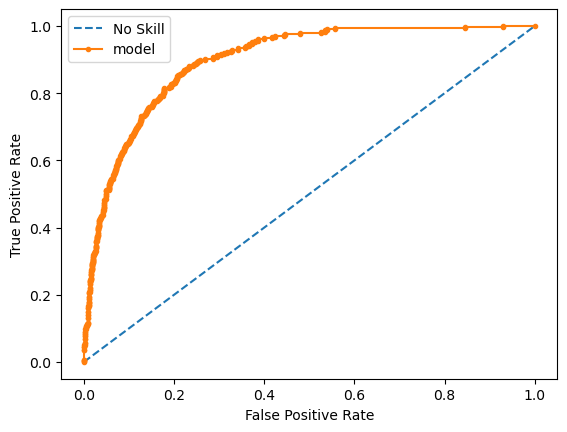

In [38]:
ns_probs = [0 for _ in range(test.shape[0])]
# fit a model

# predict probabilities
model_probs = clf.predict_proba(test[feature_columns])[:, 1]
# calculate scores
ns_auc = roc_auc_score(test['label'], ns_probs)
model_auc = roc_auc_score(test['label'], model_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (model_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test['label'], ns_probs)
model_fpr, model_tpr, _ = roc_curve(test['label'], model_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(model_fpr, model_tpr, marker='.', label='model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
test_scores=pd.concat([pd.Series(model_probs,index=test.index),test['symbol']],axis=1).rename(columns={0:'score'})

In [41]:
test.symbol.unique()

['AAPL', 'GOOGL', 'MSFT', 'NVDA']
Categories (4, object): ['AAPL', 'GOOGL', 'MSFT', 'NVDA']

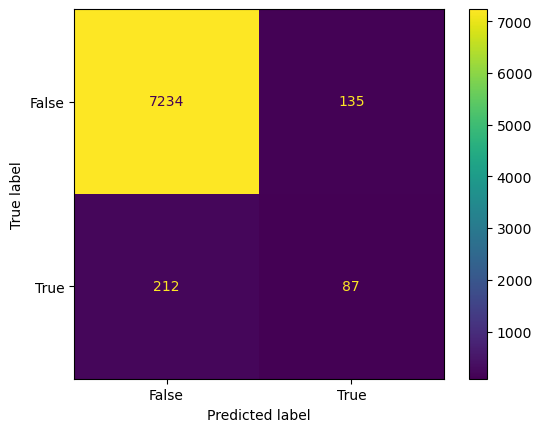

In [42]:
cm = confusion_matrix(test['label'], test_scores.score>0.3, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

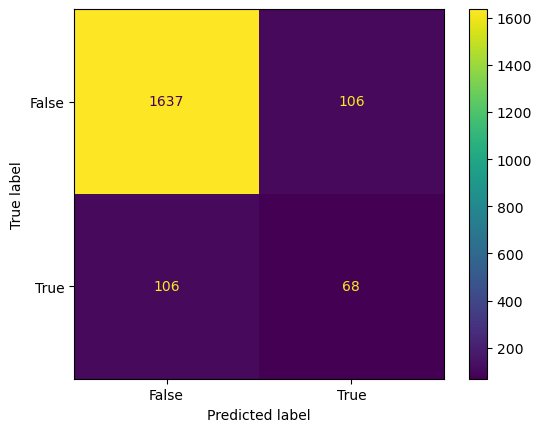

In [43]:
symbol='NVDA'
cm = confusion_matrix(test[test.symbol==symbol]['label'], test_scores[test.symbol==symbol].score>0.3, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

In [44]:
# ROC history: iteration 1: ROC AUC=0.809

In [46]:
feature_importance=pd.DataFrame(clf.feature_importances_,feature_columns).rename(columns={0:'gain'})

In [51]:
feature_importance.sort_values(by='gain',ascending=False).iloc[:50]

,gain
volatility_dcw,11618.695422
last_value_nrmlz_trade_count,8492.987775
hour_of_day,6535.634663
volatility_kcw,5301.535360
ratio_last_mean5L_delta_HL,1185.928009
diff_2L_trade_count,995.896508
diff_2L_volume,902.221847
ratio_last_mean3L_delta_HL,847.185808
std_80L_low,724.915613
zscore_last_past80_low,564.429211
